In [2]:
import os
import cv2
import random
import imutils
import math
import numpy as np
import pandas as pd
from easyocr import Reader as EasyOCR
from typing import Any
from openpyxl import Workbook
from matplotlib import pyplot as plt
from paddleocr import PaddleOCR
from tensorflow.keras.preprocessing import image as tfimage
from trdg.generators import GeneratorFromStrings

Missing modules for handwritten text generation.


In [3]:
ALPHABET = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
DATASET_PATH = f'dataset'

# type decls
cv2.Image = np.ndarray
cv2.Contour = np.ndarray

# shows an image on ipynb
def imshow(img: cv2.Image) -> None:
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def grayscale(img: cv2.Image) -> cv2.Image:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Get all testing images into an array

In [4]:
images = []
for (id, filename) in enumerate(os.listdir(DATASET_PATH)):
    image = cv2.imread(f"{DATASET_PATH}/{filename}")
    images.append((filename, image))

Defines image cropper to center the text in the image

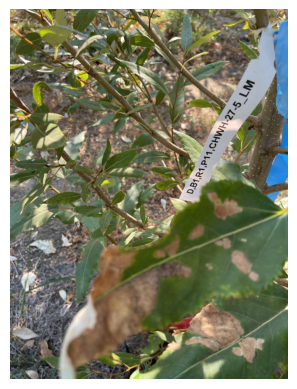

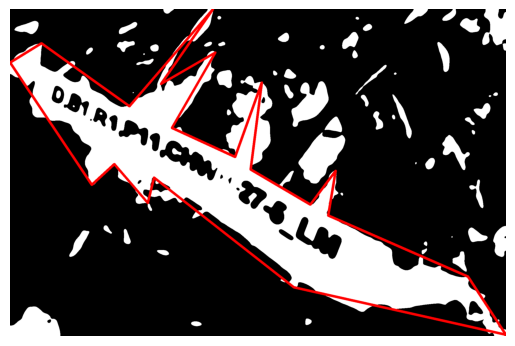

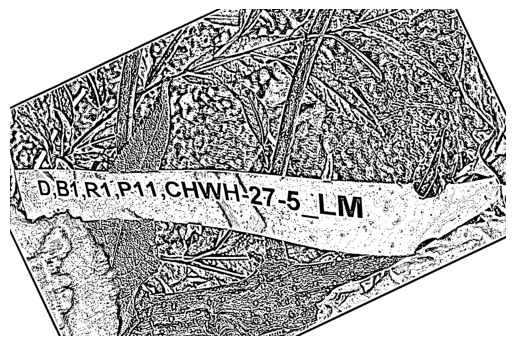

In [18]:
def process_image(img: cv2.Image, strength: int = 1) -> cv2.Image:
    gray = grayscale(img)
    blur = tfimage.img_to_array(cv2.medianBlur(gray, 5), dtype='uint8')
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, strength)
    return thresh

def get_largest_contour(img: cv2.Image, show_contours: bool = False) -> cv2.Contour:
    gray = grayscale(img)
    blur = cv2.GaussianBlur(gray, (51, 51), 0)
    thresh = cv2.threshold(blur, 150, 255, 0)[1]
    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    return thresh, sorted(contours, key=cv2.contourArea, reverse=True)[0]

def crop_image(img: cv2.Image, debug: bool = False) -> cv2.Image:

    if debug: imshow(img)

    big_contour = get_largest_contour(img)[1]
    x, y, w, h = cv2.boundingRect(big_contour)
    newimg = img[y:y+h, x:x+w]

    # perform 90-deg rotation if the cropped image is wider than tall
    if h > w: newimg = np.array([[newimg[j][i] for j in reversed(range(len(newimg)))] for i in range(len(newimg[0]))])

    # get the longest line in the approximation
    thresh, newimg_big_contour = get_largest_contour(newimg)
    approx = cv2.approxPolyDP(newimg_big_contour, 0.010*cv2.arcLength(newimg_big_contour, True), True)
    simplified_approx = list(map(lambda x: tuple(x[0]), approx))
    max_lines = sorted(
        zip(simplified_approx, simplified_approx[1:] + [simplified_approx[0]]),  # connects all the points with the adjacent one
        key=lambda l: (l[0][0]-l[1][0])**2 + (l[0][1]-l[1][1])**2                # distance formula
    )[-2:]

    def get_angle(line: tuple[tuple[int]]) -> float:

        # flatten the longest line, from / to __
        y_dist = line[0][1]-line[1][1]
        x_dist = line[0][0]-line[1][0]
        angle = math.degrees(math.atan(y_dist/x_dist))
        return angle

    if debug:
        drawn_contours = cv2.drawContours(cv2.cvtColor(thresh.copy(), cv2.COLOR_GRAY2BGR), [approx], -1, (0, 0, 255), 10)
        imshow(drawn_contours)
        
    newimg = imutils.rotate(newimg, angle=float(np.average([*map(get_angle, max_lines)])))

    return newimg

test_index = 8
img = crop_image(images[test_index][1], debug=True)
img = process_image(img)
imshow(img)

Generate synthetic data to train neural network

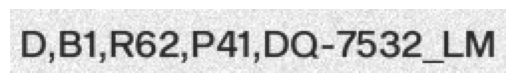

In [5]:
ALPHABET = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
IMG_COUNT = 100
DATA_PATH = 'synthetic-data'
IMAGES_PATH = f'{DATA_PATH}/images'

os.system(f"{'rm -rf' if os.name != 'nt' else 'rmdir /s /q'} {DATA_PATH}")
os.system(f"mkdir {DATA_PATH} {IMAGES_PATH}")
os.system(f"echo '*' > {DATA_PATH}/.gitignore")

def get_random_text():
    treatment = random.choice(['C', 'D'])
    block = f"B{random.choice(['1', '2'])}"
    row = f"R{random.randint(1, 99)}"
    position = f"P{random.randint(1, 99)}"
    
    gen_length = random.randint(2, 4)
    num_count = random.choices([1, 2, 3], weights=(70, 15, 15))[0]
    num_lengths = random.choices([1, 2, 3, 4], weights=(15, 15, 15, 55), k=num_count)

    genotype = (
        "".join([ALPHABET[random.randint(0, 25)] for _ in range(gen_length)]) + 
        f"-{'-'.join([str(random.randint(10**(i-1), 10**i-1)) for i in num_lengths])}_LM"
    )

    return ','.join([treatment, block, row, position, genotype])

# generate the new images, limiting count
generator = GeneratorFromStrings(
    [get_random_text() for _ in range(1000)],
    random_blur=True,
    random_skew=True,
    fonts=['assets/image_font.ttf']
)
i = 0
for img, lbl in generator:
    if i == IMG_COUNT: break
    img.save(f'{IMAGES_PATH}/{lbl}_{i}.png')
    i += 1

# randomly selects one image for exemplary purposes
example_img = random.choice(os.listdir(IMAGES_PATH))
imshow(cv2.imread(f"{IMAGES_PATH}/{example_img}"))

C,B2,R29,P40,GW-9813 LM


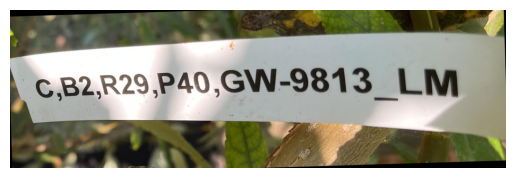

D,B1,R8,P6,BESC-415LM


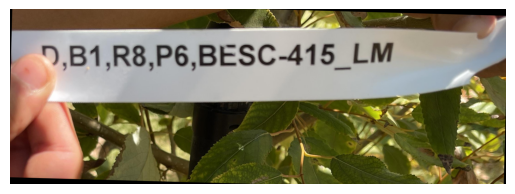

None


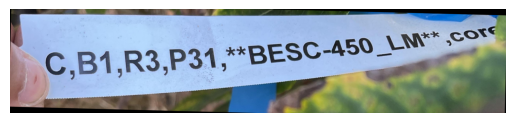

C,B2,R25,P41,BESC-358 LM


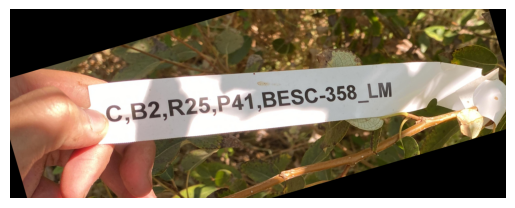

C.B1.R6.P10,GW-9847 LM


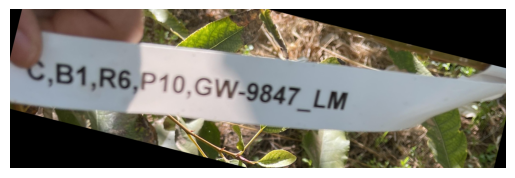

D,B1,R6,P33,BESC-134LM


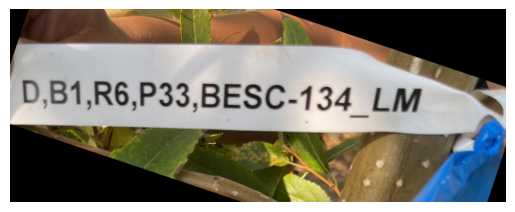

C,Bz,R32,P53,BESC-207LM


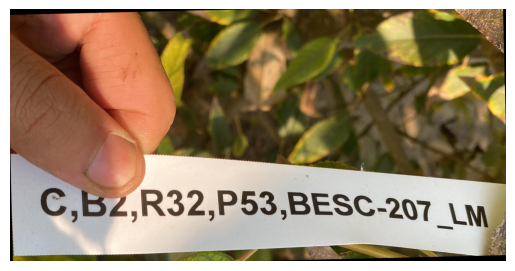

None


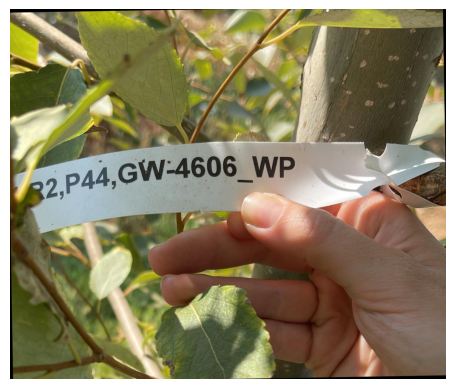

None


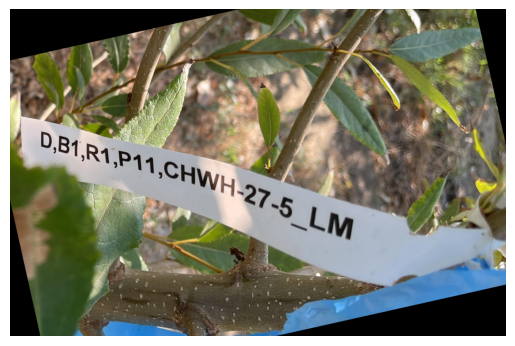

In [8]:
def get_text(text: Any, mode: str) -> str:
    if mode == "paddle":
        output = ""
        if text == [[]]:
            return None
        for item in text[0]:
            output += item[1][0]
        # if len(output) < 10:
        #     return None
        return output
    elif mode == "easy":
        output = ""
        for item in sorted(text, key=lambda x: x[0][0]):
            output += item[1]
        return output
            
PADDLE_OCR = PaddleOCR(use_angle_cls=True, lang='en', show_log=False, rotation=True)
# EASY_OCR = EasyOCR(['en'])
cropped_images = map(lambda x: crop_image(x[1]), images)
textImg = []
for image in cropped_images:
    if (text:=get_text(PADDLE_OCR.ocr(image), mode="paddle")) is None:
        bw_image = process_image(image, strength=-2)
        text = get_text(PADDLE_OCR.ocr(bw_image), mode="paddle")
        # image = bw_image
    textImg.append(text)
    print(text)
    imshow(image)

In [7]:
texts = []
for i in textImg:
    for v in i:
        for c in v:
            texts.append(c[-1])
print(texts)

[('C,B2,R29,P40,GW-9813 LM', 0.9822989702224731), ('D,B1,R8,P6,BESC-415LM', 0.9266588091850281), ('C,B2,R25,P41,BESC-358 LM', 0.9715964794158936), ('C.B1.R6.P10,GW-9847 LM', 0.9375556707382202), ('D,B1,R6,P33,BESC-134LM', 0.9708990454673767), ('C,Bz,R32,P53,BESC-207', 0.9565902948379517), ('LM', 0.8878271579742432), ('MP', 0.7289841175079346)]


In [8]:
real_text = []
for i in texts:
    for j in i:
        if isinstance(j,str):
            real_text.append(j)
print(real_text)

['C,B2,R29,P40,GW-9813 LM', 'D,B1,R8,P6,BESC-415LM', 'C,B2,R25,P41,BESC-358 LM', 'C.B1.R6.P10,GW-9847 LM', 'D,B1,R6,P33,BESC-134LM', 'C,Bz,R32,P53,BESC-207', 'LM', 'MP']


In [9]:
arrayOftext = np.array(real_text)
print(arrayOftext)

['C,B2,R29,P40,GW-9813 LM' 'D,B1,R8,P6,BESC-415LM'
 'C,B2,R25,P41,BESC-358 LM' 'C.B1.R6.P10,GW-9847 LM'
 'D,B1,R6,P33,BESC-134LM' 'C,Bz,R32,P53,BESC-207' 'LM' 'MP']


In [10]:
arrayOftext.reshape(-1,1)
df = pd.DataFrame(columns = ['control','B','Row','Pos','Geno'] )
lst = []
for i in arrayOftext:
    if ',' in i:
        listOfi = i.split(',')
        while len(listOfi) != 5:
            listOfi.append("N/A")
        lst.append(listOfi)
        
        print(listOfi)
    else:
        listOfi = i.split('.')
        while len(listOfi) != 5:
            listOfi.append("N/A")
        lst.append(listOfi)
        
        print(listOfi)
df_extended = pd.DataFrame(lst,columns = ['control','B','Row','Pos','Geno'])

for col in df_extended:
    df[col] = df_extended[col]

['C', 'B2', 'R29', 'P40', 'GW-9813 LM']
['D', 'B1', 'R8', 'P6', 'BESC-415LM']
['C', 'B2', 'R25', 'P41', 'BESC-358 LM']
['C.B1.R6.P10', 'GW-9847 LM', 'N/A', 'N/A', 'N/A']
['D', 'B1', 'R6', 'P33', 'BESC-134LM']
['C', 'Bz', 'R32', 'P53', 'BESC-207']
['LM', 'N/A', 'N/A', 'N/A', 'N/A']
['MP', 'N/A', 'N/A', 'N/A', 'N/A']


In [11]:
df.head()

,control,B,Row,Pos,Geno
0,C,B2,R29,P40,GW-9813 LM
1,D,B1,R8,P6,BESC-415LM
2,C,B2,R25,P41,BESC-358 LM
3,C.B1.R6.P10,GW-9847 LM,N/A,N/A,N/A
4,D,B1,R6,P33,BESC-134LM


In [12]:
EXAMPLE_DATA = pd.DataFrame({
    'filename': ['example1.png', 'example2.png'],
    'treatment': ['C', 'D'],
    'block': ['1', '2'],
    'row': ['54', '23'],
    'position': ['12', '10'],
    'genotype': ['BESC-4590_LM', 'BESC-4230_LM']
})

def make_sheet(data: pd.DataFrame, excel_file: str) -> None:
    wb = Workbook()
    worksheet = wb.active
    
    # For writing the Header Rows on Excel
    headers = [*data.keys()]
    worksheet.append(headers)

    # For writing the data rows for each image in the dataset
    for i in range(len(data)):
        row = [data[header][i] for header in headers]
        worksheet.append(row)

    wb.save(excel_file)
        
make_sheet(EXAMPLE_DATA, 'example.xlsx')